# Train Baseline

This notebook shows how to train the baseline model for this competition.

In [1]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))


import torch
import wandb

from utils.train import TrainConfig, run_train_model
from utils.augmentations import get_default_transform
from utils import creating_dataset

# this is the implementation of the custom baseline model
from utils import hvatnet

## Define trainer configuration

The `TrainConfig` class is used to train the baseline model - have a look at the parameters it has!

In [2]:
train_config = TrainConfig(exp_name='test_2_run_fedya', p_augs=0.3, batch_size=64, eval_interval=150, num_workers=0)


In [3]:
train_config

TrainConfig(exp_name='test_2_run_fedya', batch_size=64, grad_accum=1, p_augs=0.3, learning_rate=0.001, weight_decay=1e-05, max_steps=100000, eval_interval=150, use_scheduler=True, warmup_iters=2000, lr_decay_iters=50000, num_workers=0, pin_memory=True, grad_clip=1.0, mixed_precision=False, visualize_predictions=False)

## Load data

In [4]:
DATA_PATH = r"/msc/home/vsharm64/projects/BCI_Kaggle/dataset_v2_blocks/dataset_v2_blocks"

def count_parameters(model): 
    n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    n_total = sum(p.numel() for p in model.parameters())
    print(f"Total: {n_total/1e6:.2f}M, Trainable: {n_trainable/1e6:.2f}M")
    return n_total, n_trainable


    
## Data preparation
transform = get_default_transform(train_config.p_augs)
data_paths = dict(datasets=[DATA_PATH],
                    hand_type = ['left', 'right'], # [left, 'right']
                    human_type = ['health', 'amputant'], # [amputant, 'health']
                    test_dataset_list = ['fedya_tropin_standart_elbow_left'])
data_config = creating_dataset.DataConfig(**data_paths,down_sample_target = 1)
train_dataset, test_dataset = creating_dataset.get_datasets(data_config, transform=transform)



Getting val datasets
Number of moves: 72 | Dataset: fedya_tropin_standart_elbow_left
Reorder this dataset fedya_tropin_standart_elbow_left True
Getting train datasets
Number of moves: 72 | Dataset: fedya_tropin_standart_elbow_left
Reorder this dataset fedya_tropin_standart_elbow_left True
Number of moves: 70 | Dataset: valery_first_standart_elbow_left
Reorder this dataset valery_first_standart_elbow_left True
Number of moves: 135 | Dataset: alex_kovalev_standart_elbow_left
Reorder this dataset alex_kovalev_standart_elbow_left True
Number of moves: 72 | Dataset: anna_makarova_standart_elbow_left
Reorder this dataset anna_makarova_standart_elbow_left True
Number of moves: 62 | Dataset: artem_snailbox_standart_elbow_left
Reorder this dataset artem_snailbox_standart_elbow_left True
Number of moves: 144 | Dataset: matthew_antonov_standart_elbow_left
Reorder this dataset matthew_antonov_standart_elbow_left True
Number of moves: 144 | Dataset: misha_korobok_standart_elbow_left
Reorder this da

## Initialize the model
As you can see below, the model has a number of hyperparameters specifying its architecture and parameters. These are the parameters used to generate the baseline predictions.

In [5]:
model_config = hvatnet.Config(n_electrodes=8, n_channels_out=20,
                            n_res_blocks=3, n_blocks_per_layer=3,
                            n_filters=128, kernel_size=3,
                            strides=(2, 2, 2), dilation=2, 
                            small_strides = (2, 2))
model = hvatnet.HVATNetv3(model_config)
count_parameters(model)

Number of parameters: 4210788
Total: 4.21M, Trainable: 4.21M


(4210788, 4210788)

Remember that the predictions are downsampled at 25Hz from the data originally recorded at 200Hz. The `hvatnet` model used here, automatically and correctly downsamples the data during predictions. Make sure that your model's oputput is also downsampled!

In [5]:
X, Y = train_dataset[0]
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

Y_hat = model(torch.tensor(X).unsqueeze(0)).squeeze().detach().numpy()

print(f"Predictions shape: {Y_hat.shape}")

assert Y.shape == Y_hat.shape, "Predictions have the wrong shape!"

X shape: (8, 256), Y shape: (20, 256)


NameError: name 'model' is not defined

In [7]:
X

array([[ 0.01029423,  0.22892118, -0.23529267, ..., -0.09362778,
        -0.1514707 ,  0.0308821 ],
       [-0.00177585,  0.248206  , -0.37791416, ..., -0.02245655,
        -0.13940063,  0.08734737],
       [ 0.03341821,  0.01585603,  0.15336123, ..., -0.00673543,
        -0.17271878,  0.11151008],
       ...,
       [ 0.01686562, -0.0083641 , -0.03529412, ..., -0.00392157,
        -0.05163878, -0.00628026],
       [ 0.03008462,  0.00044857, -0.03529412, ..., -0.00392157,
        -0.07367044, -0.03271825],
       [ 0.0054567 ,  0.04059722, -0.0516781 , ..., -0.02865114,
        -0.22232926,  0.1409951 ]], dtype=float32)

In [8]:
len(train_dataset)

99990

In [9]:
torch.tensor(5)

tensor(5)

In [10]:
torch.eye(8,8)

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]])

In [17]:
x = torch.from_numpy(X).unsqueeze(dim=0)
targets = torch.from_numpy(Y).unsqueeze(dim=0)
print(x.shape,targets.shape)

torch.Size([1, 8, 256]) torch.Size([1, 20, 32])


In [18]:
x.permute(0, 2, 1).shape

torch.Size([1, 256, 8])

In [19]:
torch.eye(8,8)

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]])

In [20]:
weights[:,0].sum()

tensor(1.0000)

In [21]:
weights = torch.softmax(torch.eye(18,8)*torch.tensor(5),dim=0)
weights

tensor([[0.8972, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060],
        [0.0060, 0.8972, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060],
        [0.0060, 0.0060, 0.8972, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060],
        [0.0060, 0.0060, 0.0060, 0.8972, 0.0060, 0.0060, 0.0060, 0.0060],
        [0.0060, 0.0060, 0.0060, 0.0060, 0.8972, 0.0060, 0.0060, 0.0060],
        [0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.8972, 0.0060, 0.0060],
        [0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.8972, 0.0060],
        [0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.8972],
        [0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060],
        [0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060],
        [0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060],
        [0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060],
        [0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060],
        [0.0060, 0.0060, 0.0060, 0.006

In [22]:
torch.matmul(x.permute(0, 2, 1),torch.softmax(torch.eye(8,8)*torch.tensor(5),dim=0))

tensor([[[ 0.0104, -0.0010,  0.0324,  ...,  0.0167,  0.0292,  0.0058],
         [ 0.2204,  0.2387,  0.0183,  ..., -0.0047,  0.0037,  0.0417],
         [-0.2275, -0.3628,  0.1411,  ..., -0.0378, -0.0378, -0.0533],
         ...,
         [-0.0900, -0.0225, -0.0076,  ..., -0.0049, -0.0049, -0.0284],
         [-0.1502, -0.1388, -0.1704,  ..., -0.0555, -0.0764, -0.2174],
         [ 0.0324,  0.0860,  0.1089,  ..., -0.0029, -0.0279,  0.1368]]])

In [23]:
x = torch.from_numpy(X).unsqueeze(dim=0)
targets = torch.from_numpy(Y).unsqueeze(dim=0)
print(x.shape,targets.shape)

import torch.nn.functional as F

print(1, x.shape)
x = model.tune_module(torch.from_numpy(X).unsqueeze(dim=0))
print(2, x.shape)
# denoising part
x = model.spatial_reduce(x)
print(3, x.shape)
x = model.denoiser(x)
print(4, x.shape)
# extract features
# TODO: add mapper and change encoder to return all features
outputs = model.encoder(x)
print(5, len(outputs))
emg_features = outputs[-1] # 25 fps features
print(6, emg_features.shape)
# decode features
# 1. simple way:  mapper + pred_head + quat conversion
# emg_features = self.mapper(emg_features)

# 2. Unet way:  encoder + mapper + decoder + quat conversion
outputs_small = model.encoder_small(emg_features)
print(7, len(outputs_small))
print(8, outputs_small[-1])
outputs_small[-1] = model.mapper(outputs_small[-1])
print(9, outputs_small[-1].shape)
print(10, outputs_small[-1])
emg_features = model.decoder_small(outputs_small)[-1]
print(11, emg_features.shape)

# 3. RNN way 
# emg_features  = emg_features.permute(0, 2, 1) # size [batch, n_filters, time]
# res = self.rnn(emg_features)
# emg_features = res.permute(0, 2, 1)

pred = model.simple_pred_head(emg_features)
print(12, pred.shape)

# if targets is None:
#     return pred

loss = F.l1_loss(pred, targets)
print(loss)


torch.Size([1, 8, 256]) torch.Size([1, 20, 32])
1 torch.Size([1, 8, 256])
2 torch.Size([1, 8, 256])
3 torch.Size([1, 128, 256])
4 torch.Size([1, 128, 256])
5 4
6 torch.Size([1, 128, 32])
7 3
8 tensor([[[ 0.0554,  0.0498,  0.0336,  ...,  0.0983,  0.0658,  0.0161],
         [ 0.0721,  0.0333, -0.0542,  ...,  0.0324,  0.0212,  0.0199],
         [-0.0352, -0.0443, -0.0354,  ..., -0.0699, -0.1481, -0.0895],
         ...,
         [ 0.0689,  0.0680,  0.0645,  ..., -0.0085, -0.0048,  0.0419],
         [-0.0011,  0.0398, -0.0280,  ..., -0.0686, -0.0245,  0.0344],
         [ 0.1509,  0.1519,  0.1843,  ...,  0.1252,  0.1671,  0.1522]]],
       grad_fn=<ConvolutionBackward0>)
9 torch.Size([1, 128, 8])
10 tensor([[[ 0.0208,  0.0189,  0.0276,  ...,  0.0250,  0.0151,  0.0080],
         [-0.0067, -0.0063, -0.0128,  ..., -0.0048, -0.0132, -0.0213],
         [ 0.0057,  0.0050,  0.0081,  ...,  0.0088,  0.0094,  0.0159],
         ...,
         [ 0.0167,  0.0281,  0.0256,  ...,  0.0247,  0.0246,  0.0122],

51it [00:01, 36.60it/s]


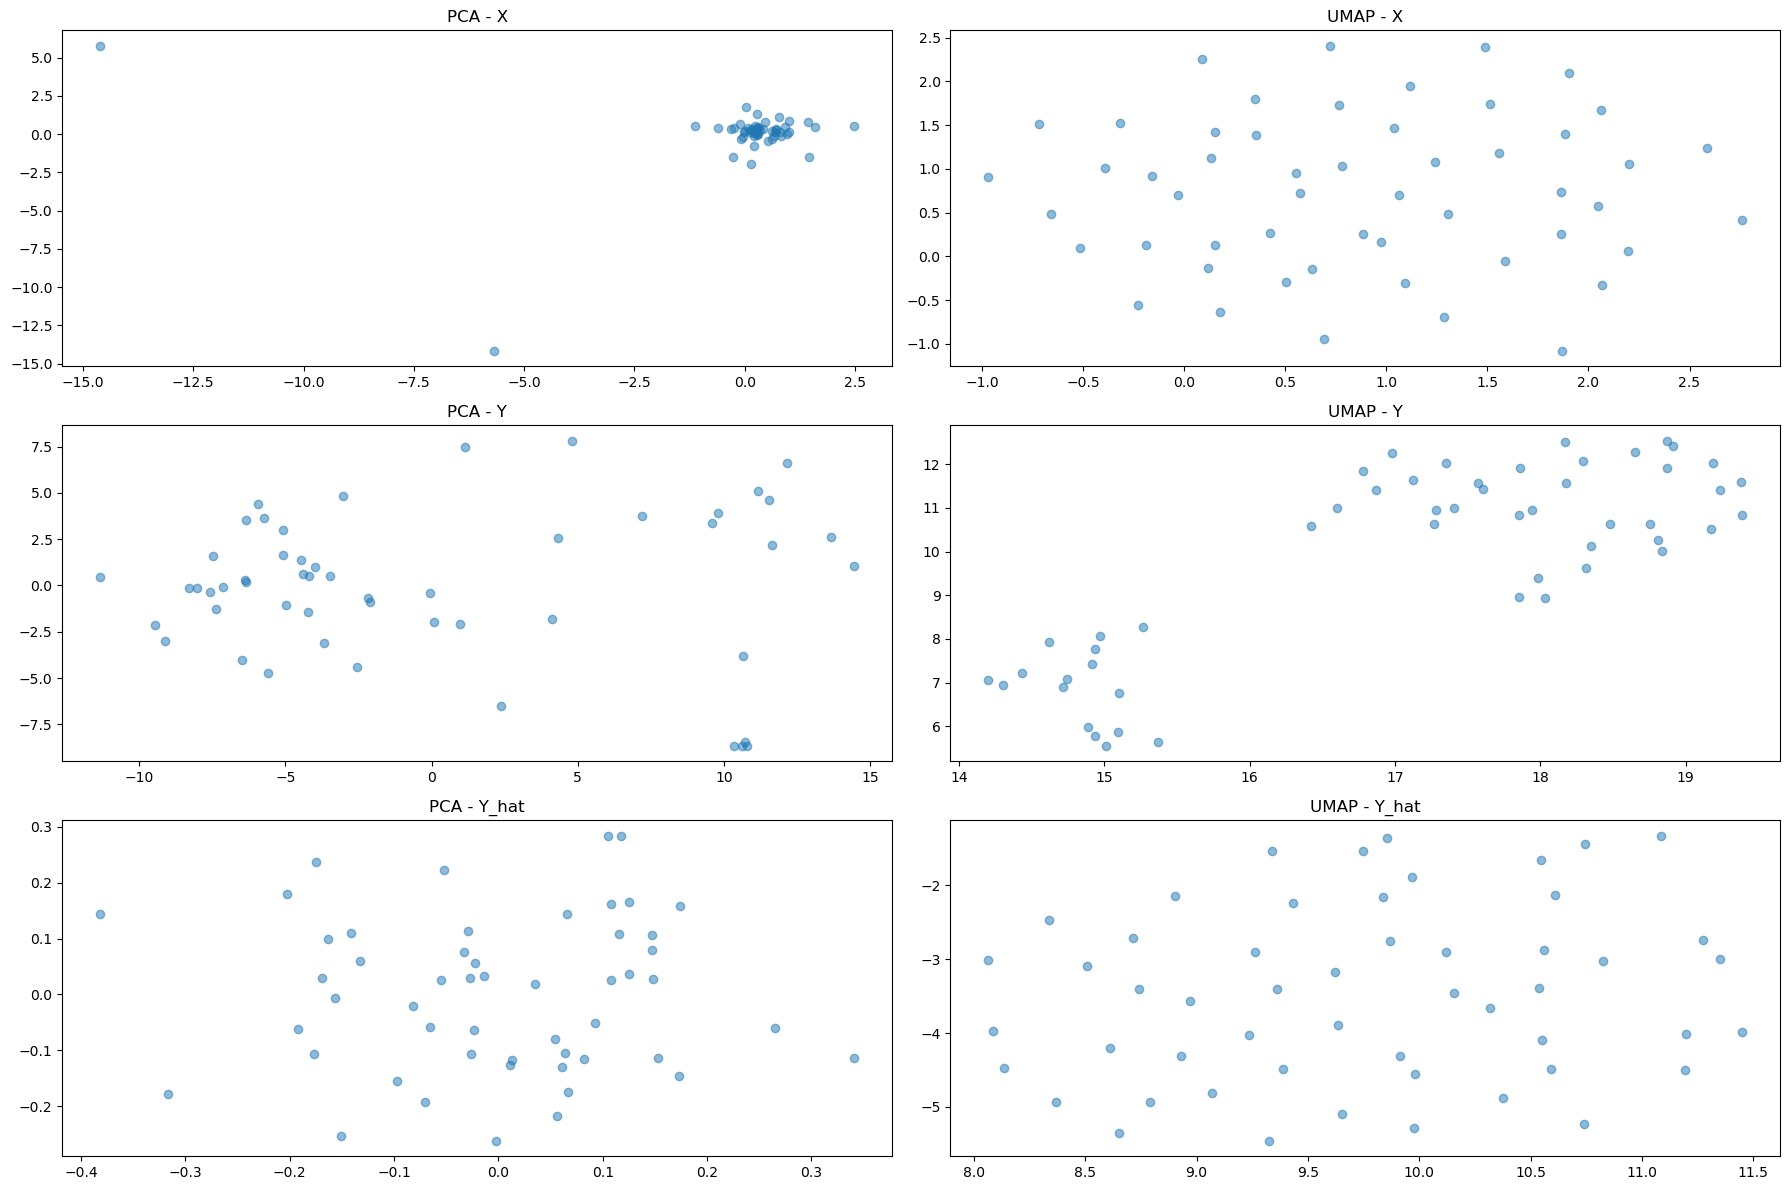

In [21]:
import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
import seaborn as sns

# Example shapes from your data
# X_shape = (8, 256)
# Y_shape = (20, 32)

# Generate dummy data for demonstration
# train_dataset = [(np.random.randn(*X_shape), np.random.randn(*Y_shape)) for _ in range(100)]

# Placeholder model - replace with your actual model
# class DummyModel(torch.nn.Module):
#     def forward(self, x):
#         return torch.randn(1, *Y_shape)

# model = DummyModel()

# Collect all X, Y, and Y_hat data
X_data = []
Y_data = []
Y_hat_data = []

for idx, (X, Y) in tqdm.tqdm(enumerate(train_dataset)):
    X_data.append(X.flatten())
    Y_data.append(Y.flatten())
    Y_hat = model(torch.tensor(X).unsqueeze(0)).squeeze().detach().numpy()
    Y_hat_data.append(Y_hat.flatten())
    if idx > 50:
        break

X_data = np.array(X_data)
Y_data = np.array(Y_data)
Y_hat_data = np.array(Y_hat_data)

# Perform PCA and UMAP for X_data
pca_X = PCA(n_components=2)
pca_X_result = pca_X.fit_transform(X_data)

umap_X = umap.UMAP(n_components=2)
umap_X_result = umap_X.fit_transform(X_data)

# Perform PCA and UMAP for Y_data
pca_Y = PCA(n_components=2)
pca_Y_result = pca_Y.fit_transform(Y_data)

umap_Y = umap.UMAP(n_components=2)
umap_Y_result = umap_Y.fit_transform(Y_data)

# Perform PCA and UMAP for Y_hat_data
pca_Y_hat = PCA(n_components=2)
pca_Y_hat_result = pca_Y_hat.fit_transform(Y_hat_data)

umap_Y_hat = umap.UMAP(n_components=2)
umap_Y_hat_result = umap_Y_hat.fit_transform(Y_hat_data)

# Plotting PCA results
plt.figure(figsize=(18, 12))

# PCA for X_data
plt.subplot(3, 2, 1)
plt.scatter(pca_X_result[:, 0], pca_X_result[:, 1], alpha=0.5)
plt.title('PCA - X')

# PCA for Y_data
plt.subplot(3, 2, 3)
plt.scatter(pca_Y_result[:, 0], pca_Y_result[:, 1], alpha=0.5)
plt.title('PCA - Y')

# PCA for Y_hat_data
plt.subplot(3, 2, 5)
plt.scatter(pca_Y_hat_result[:, 0], pca_Y_hat_result[:, 1], alpha=0.5)
plt.title('PCA - Y_hat')

# UMAP for X_data
plt.subplot(3, 2, 2)
plt.scatter(umap_X_result[:, 0], umap_X_result[:, 1], alpha=0.5)
plt.title('UMAP - X')

# UMAP for Y_data
plt.subplot(3, 2, 4)
plt.scatter(umap_Y_result[:, 0], umap_Y_result[:, 1], alpha=0.5)
plt.title('UMAP - Y')

# UMAP for Y_hat_data
plt.subplot(3, 2, 6)
plt.scatter(umap_Y_hat_result[:, 0], umap_Y_hat_result[:, 1], alpha=0.5)
plt.title('UMAP - Y_hat')

plt.tight_layout()
plt.show()


(12, 640)

The following code trains the baseline model using training code defined in `utils`.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

run_train_model(model, (train_dataset, test_dataset), train_config, device)

Completed initialization of scheduler
******************************************************************************************************************************************************

overall_steps 150: 0.2935050427913666
val loss: 0.32158514857292175
saved model:  step_150_loss_0.3216.safetensors


******************************************************************************************************************************************************

overall_steps 300: 0.2603130340576172
val loss: 0.3364621698856354


******************************************************************************************************************************************************

overall_steps 450: 0.2688163220882416
val loss: 0.31020545959472656
saved model:  step_450_loss_0.3102.safetensors


******************************************************************************************************************************************************

overall_steps 600: 0.27973946928977966
val loss: 0.